# Create dataset

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# combine game data
df1 = pd.read_csv('data/large_board_dataset2.csv')
df2 = pd.read_csv('data/large_board_dataset3.csv')
df3 = pd.read_csv('data/large_board_dataset4.csv')
df4 = pd.read_csv('data/large_board_dataset5.csv')
df5 = pd.read_csv('data/large_board_dataset6.csv')

# fix game numbers
df2['game'] += df1['game'].max() + 1
df3['game'] += df2['game'].max() + 1
df4['game'] += df3['game'].max() + 1
df5['game'] += df4['game'].max() + 1

# combine dfs
df = pd.concat([df1, df2, df3, df4, df5])

print(f'Length of dataset {len(df)}')

Length of dataset 327457


In [3]:
# include game info
df1 = pd.read_csv('data/large_board_dataset2_game_info.csv')
df2 = pd.read_csv('data/large_board_dataset3_game_info.csv')
df3 = pd.read_csv('data/large_board_dataset4_game_info.csv')
df4 = pd.read_csv('data/large_board_dataset5_game_info.csv')
df5 = pd.read_csv('data/large_board_dataset6_game_info.csv')

# fix game numbers
df2['game'] += df1['game'].max() + 1
df3['game'] += df2['game'].max() + 1
df4['game'] += df3['game'].max() + 1
df5['game'] += df4['game'].max() + 1

info_df = pd.concat([df1, df2, df3, df4, df5]).reset_index(drop=True)
info_df['who_won'] = info_df['who_won'].str.replace(r'\w-', '', regex=True)
info_df.head()

df = df.merge(info_df, on='game')

In [5]:
# save tuple for later use in exploration (couldn't use arrays)
df['x_tuple'] = df['x']

# change boards to np arrays
df["x"] = df["x"].apply(lambda x: np.array(ast.literal_eval(x)).reshape(2, 6, 7))

# change perspective for yellow to be the same as red (switch the first index or switch the last index once we fix shape)
def switch_players(board):
    if board["whose_turn"] != "red":
        # Flip the layers to make each board look like it's from the perspective of "red", aka plus
        board["x"] = board["x"][::-1, :, :]
    return board

df = df.apply(switch_players, axis=1)

def flip_board(board, col):
    new_board = np.flip(board, axis = 2)
    # for now this needs to be done by index 2 because the input is still 2x6x7, but this can easily be updated
    new_column = 6 - col
    return new_board, new_column

flipped_x = []
flipped_y = []

for index, row in df.iterrows():
    board = row["x"]
    col = row["y"]
    new_board, new_column = flip_board(board, col)

    flipped_x.append(new_board)
    flipped_y.append(new_column)

new_df = pd.DataFrame({"x": flipped_x, "y": flipped_y})

# insert matching previous columns
new_df = pd.concat([new_df, df.loc[:, 'whose_turn':'who_won']], axis=1)
new_df['game'] += 15000

# create tuple again
new_df['x_tuple'] = df['x'].apply(lambda x:tuple(x.ravel()))

# append the df of flipped boards
df = pd.concat([df, new_df], ignore_index = True)

In [16]:
df.shape

(654914, 9)

There are 579136 unique x's in our dataset.
88.43% of the x's are unique in our dataset.
There are 30000 games in our dataset.


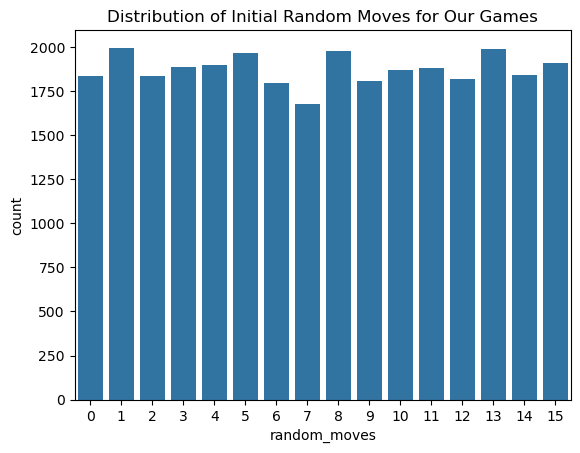

Relatively equal distribution of random moves

Games each player won


who_won
yellow    14874
red       13862
tie        1264
Name: count, dtype: int64


These are all the first moves that were played and their frequency:


y
3    1742
4      43
2      43
1       4
5       4
6       1
0       1
Name: count, dtype: int64

You can see that MCTS has picked up on that the middle column is the best first move.


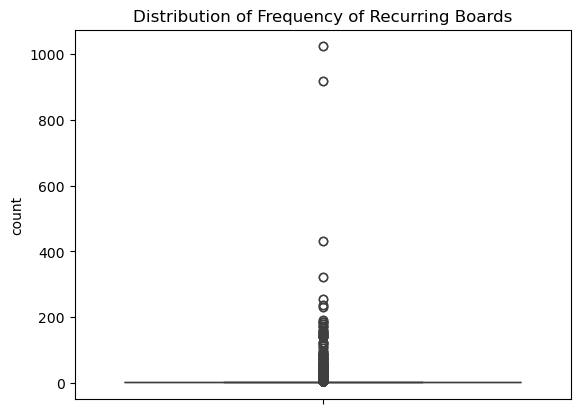

Most recurring boards only occur twice, but some occur as many as 1000 times.


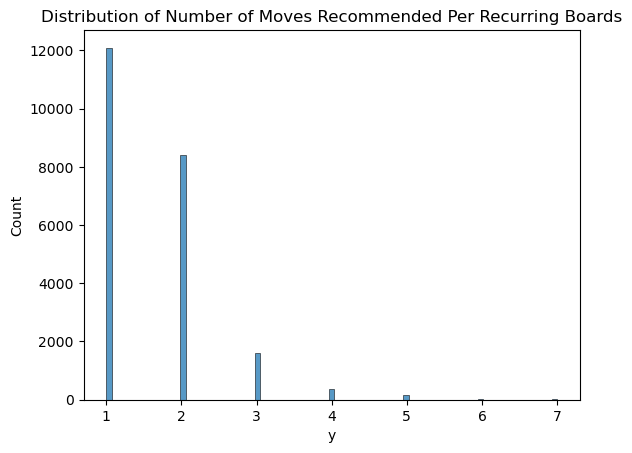

Some of the recurring boards only select one move. The choice is clear there. Should look into what to select for the boards with more than one move.
There are 22678 recurring boards that we could potentially restrict moves for.
How should we decide to remove moves from the dataset? Should we make sure that a move has been a certain proportion of times out of more than x moves?
Of those recurring boards, 3624 of them are played more than 10 times, and we could select the most common move for boards with more than 10 moves.
Alternatively, we could select moves for the 1594 boards with more than 20 moves in our dataset.


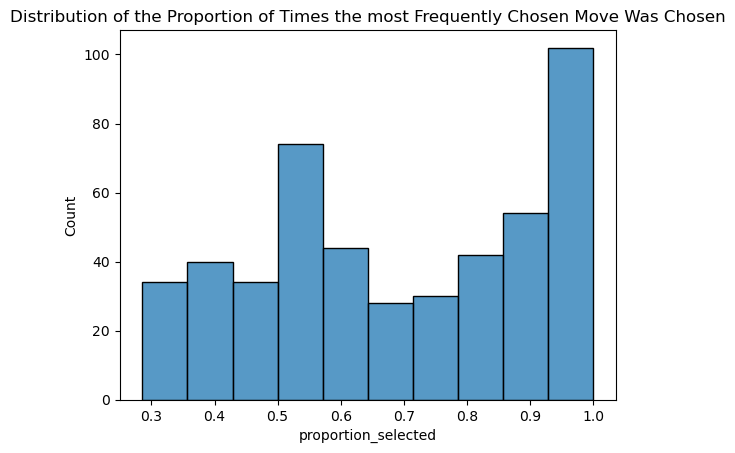

We could remove 33150 rows if we selected moves that have 80% selection rate. This doesn't account for sample size though.


In [21]:
# examine games

# unique x's?
unique_x = df['x_tuple'].nunique()
print(f'There are {unique_x} unique x\'s in our dataset.')
perc_unique_x = unique_x / df.shape[0] * 100
print(f'{perc_unique_x:.2f}% of the x\'s are unique in our dataset.')

# Number of games
print(f'There are {df['game'].nunique()} games in our dataset.')

# distribution of random moves
random_moves = df.groupby('game').first()['random_moves'].value_counts()
sns.barplot(x = random_moves.index, y = random_moves)
plt.title('Distribution of Initial Random Moves for Our Games')
plt.show()
print('Relatively equal distribution of random moves')

# How many games did each player win?
print('\nGames each player won')
wins = df.groupby('game').first()['who_won'].value_counts()
display(wins)

# What is the diversity of moves?
# first moves
first_moves = df[df['random_moves'] == 0].groupby('game')['y'].first()
print('\nThese are all the first moves that were played and their frequency:')
display(first_moves.value_counts())
print('You can see that MCTS has picked up on that the middle column is the best first move.')

# For repeated boards, what is the consensus among moves?
board_counts = df['x_tuple'].value_counts()
sns.boxplot(board_counts[board_counts>1])
plt.title('Distribution of Frequency of Recurring Boards')
plt.show()
print('Most recurring boards only occur twice, but some occur as many as 1000 times.')

recurring_boards_s = pd.Series(board_counts[board_counts > 1].index)
recurring_boards_df = df[df['x_tuple'].isin(recurring_boards_s)]
n_moves = recurring_boards_df.groupby('x_tuple')['y'].nunique()
sns.histplot(n_moves)
plt.title('Distribution of Number of Moves Recommended Per Recurring Boards')
plt.show()
print('Some of the recurring boards only select one move. The choice is clear there. Should look into what to select for the boards with more than one move.')
moves_counts_df = recurring_boards_df.groupby('x_tuple')['y'].value_counts().reset_index()
total_moves = recurring_boards_df.groupby('x_tuple')['y'].count().reset_index().rename(columns = {'y':'total_moves'})
moves_counts_df = moves_counts_df.merge(total_moves, on='x_tuple')
moves_counts_df['proportion_selected'] = moves_counts_df['count'] / moves_counts_df['total_moves']
print(f'There are {moves_counts_df['x_tuple'].nunique()} recurring boards that we could potentially restrict moves for.')

# How should we decide to remove moves from the dataset?
print('How should we decide to remove moves from the dataset? Should we make sure that a move has been a certain proportion of times out of more than x moves?')
print(f'Of those recurring boards, {len(moves_counts_df[moves_counts_df['total_moves'] >= 10])} of them are played more than 10 times, and we could select the most common move for boards with more than 10 moves.')
print(f'Alternatively, we could select moves for the {len(moves_counts_df[moves_counts_df['total_moves'] >= 20])} boards with more than 20 moves in our dataset.')

# distribution of the proportion of times the most frequently chosen moves
sns.histplot(moves_counts_df.loc[moves_counts_df['total_moves'] >= 20].groupby('x_tuple')['proportion_selected'].max())
plt.title('Distribution of the Proportion of Times the most Frequently Chosen Move Was Chosen')
plt.show()

# get the most frequent move for recurring boards
most_frequent_moves_df = moves_counts_df.loc[moves_counts_df.groupby('x_tuple')['proportion_selected'].idxmax()]
# how many rows would we remove if we select moves recommended more than 80% of the time?
rows_removed = most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8, 'total_moves'].sum() - len(most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8])
print(f'We could remove {rows_removed} rows if we selected moves that have 80% selection rate. This doesn\'t account for sample size though.')

rows_removed = most_frequent_moves_df.loc[
    (most_frequent_moves_df['proportion_selected'] > .8) &
    (most_frequent_moves_df['total_moves']>=10), 
    'total_moves'].sum() - len(most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8])


In [ ]:
# filter frequent moves for repeating boards?


In [24]:
# Save the dataset as .pkl
df.to_pickle("data/654914moves_2-6-7shape.pkl")
# test
df_loaded = pd.read_pickle("data/654914moves_2-6-7shape.pkl")
display(df_loaded)

# Save in alternative format
df.to_hdf("data/654914moves_2-6-7shape.h5", key="df", mode="w")
# test
df_loaded = pd.read_hdf("data/654914moves_2-6-7shape.h5")
display(df_loaded)

,x,y,whose_turn,opponent_level,player_level,game,random_moves,who_won,x_tuple
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",0,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
654909,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...",3,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654910,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...",3,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
654911,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...",2,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654912,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...",4,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_1661/1384552886.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['x', 'whose_turn', 'who_won', 'x_tuple'], dtype='object')]

  df.to_hdf("654914moves_2-6-7shape.h5", key="df", mode="w")


                                                        x  y whose_turn  \
0       [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...  0        red   
1       [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...  4     yellow   
2       [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...  3        red   
3       [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...  4     yellow   
4       [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...  3        red   
...                                                   ... ..        ...   
654909  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...  3     yellow   
654910  [[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...  3        red   
654911  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...  2     yellow   
654912  [[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...  4        red   
654913  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...  2     yellow   

        opponent_level  player_level   game  random_moves who_won  \
0                 1500        

In [28]:
# what it looked like before
display(df.loc[0, 'x'])

# convert shape
df['x'] = df['x'].apply(lambda x:x.transpose(1, 2, 0))  # Convert (num_samples, 2, 6, 7) to (num_samples, 6, 7, 2)

# check it worked
display(df.loc[0, 'x'])

# Save the dataset as .pkl
df.to_pickle("data/654914moves_6-7-2shape.pkl")
# test
df_loaded = pd.read_pickle("data/654914moves_6-7-2shape.pkl")
display(df_loaded)

# Save in alternative format
df.to_hdf("data/654914moves_6-7-2shape.h5", key="df", mode="w")
# test
df_loaded = pd.read_hdf("data/654914moves_6-7-2shape.h5")
display(df_loaded)

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 1., 0.]]])

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.]],

       [[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]]])

,x,y,whose_turn,opponent_level,player_level,game,random_moves,who_won,x_tuple
0,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",0,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
654909,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654910,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
654911,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",2,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654912,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_1661/474229763.py:17: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['x', 'whose_turn', 'who_won', 'x_tuple'], dtype='object')]

  df.to_hdf("654914moves_6-7-2shape.h5", key="df", mode="w")


,x,y,whose_turn,opponent_level,player_level,game,random_moves,who_won,x_tuple
0,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",0,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
654909,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654910,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
654911,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",2,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654912,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,red,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
